In [1]:
%env CUDA_VISIBLE_DEVICES=0

env: CUDA_VISIBLE_DEVICES=0


In [2]:
# built-in libraries
import os
import sys
from itertools import combinations
from collections import defaultdict
import time
import pprint
import copy
from functools import reduce

# external dependencies
import pandas as pd
import seaborn as sns
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
import numpy as onp
from tqdm.notebook import tqdm
import jax.numpy as jnp

import multidms
%load_ext autoreload
%autoreload 2
%matplotlib inline

# Data Description

Here we have data from 2 Deep Mutational Scanning experiments ...TODO

# Data Summary Stats

First load in the data and do a little cleanup

In [3]:
C19 = pd.read_csv("../data/CYP2C19_abundance.csv")
C9 = pd.read_csv("../data/CYP2C9_abundance.csv")

append df's and add condition id, rename for MultiDmsData

In [4]:
rename_map = {
    "variant" : "aa_substitutions"
}
func_score_df = pd.concat(
    [
        C19.assign(condition="C19"), 
        C9.assign(condition="C9")
    ]
).rename(rename_map,axis=1)

remove 'syn' mutants

In [5]:
func_score_df = func_score_df[~func_score_df.aa_substitutions.str.contains("syn")]

conform 'X' -> '*' for stop codon variants

In [6]:
func_score_df = func_score_df.assign(aa_substitutions = func_score_df.aa_substitutions.str.replace("X", "*"))

add log fold change of weighted average.

In [7]:
func_score_df = func_score_df.assign(log_fold_wa = onp.log2(func_score_df.weighted_average / func_score_df.wt_wa))

In [8]:
func_score_df

replicate  sort             barcode  weighted_average  total_reads  \
0           Rep2   1.0  AAAAAAAACTACGTTCCA          0.844684          234   
1           Rep2   1.0  AAAAAAAATCCTAGCCGT          0.563894          937   
2           Rep2   1.0  AAAAAAAATTTTGAAAGA          0.681836          959   
3           Rep2   1.0  AAAAAAACTATTGACTTC          0.751838          217   
4           Rep2   1.0  AAAAAAATACAGGTTAAT          0.304310          215   
...          ...   ...                 ...               ...          ...   
102104      Rep3   NaN  TTTTTTTTGAAAGTCAAG          0.706138          188   
102105      Rep3   NaN  TTTTTTTTGCCAACGAAG          0.647242          166   
102106      Rep3   NaN  TTTTTTTTGTAATTCTTG          0.692603          103   
102107      Rep3   NaN  TTTTTTTTGTACGTACTT          0.496281          104   
102108      Rep3   NaN  TTTTTTTTTAATAGGCTG          0.602997          137   

            freq      type  med_nonsense     wt_wa  abundance_score  \
0       0.000008  missense      0.291621  0.826506         1.033983   
1       0.000039  missense      0.291621  0.826506         0.509032   
2       0.000038  missense      0.291621  0.826506         0.729530   
3       0.000008  missense      0.291621  0.826506         0.860404   
4       0.000017  nonsense      0.291621  0.826506         0.023724   
...          ...       ...           ...       ...              ...   
102104  0.000070  missense      0.423188  0.701742         1.015779   
102105  0.000065  missense      0.423188  0.701742         0.804345   
102106  0.000038  missense      0.423188  0.701742         0.967191   
102107  0.000044  missense      0.423188  0.701742         0.262400   
102108  0.000054  missense      0.423188  0.701742         0.645508   

       aa_substitutions start  position end condition  log_fold_wa  
0                 S162R     S       162   R       C19     0.031385  
1                 D373R     D       373   R       C19    -0.551601  
2                 D360K     D       360   K       C19    -0.277602  
3                  L71G     L        71   G       C19    -0.136604  
4                 E274*     E       274   X       C19    -1.441484  
...                 ...   ...       ...  ..       ...          ...  
102104            K247A     K       247   A        C9     0.009008  
102105            D191T     D       191   T        C9    -0.116636  
102106            Q193L     Q       193   L        C9    -0.018912  
102107            G332S     G       332   S        C9    -0.499785  
102108            K275G     K       275   G        C9    -0.218790  

[519020 rows x 16 columns]

Summary stats of quantitative columns

In [9]:
func_score_df.describe()

sort  weighted_average    total_reads          freq  \
count  421147.000000     519020.000000  519020.000000  5.190200e+05   
mean        1.494098          0.626921     438.002173  4.301402e-05   
std         0.499966          0.169343     514.979630  4.049830e-05   
min         1.000000          0.250000       1.000000  1.830817e-08   
25%         1.000000          0.500000     129.000000  1.549856e-05   
50%         1.000000          0.634832     266.000000  3.189474e-05   
75%         2.000000          0.751922     534.000000  5.738337e-05   
max         2.000000          1.000000   10376.000000  6.549612e-04   

        med_nonsense          wt_wa  abundance_score       position  \
count  519020.000000  519020.000000    519020.000000  519020.000000   
mean        0.326916       0.750214         0.709008     232.082633   
std         0.053164       0.060527         0.404777     128.451178   
min         0.289502       0.666583        -0.701318       1.000000   
25%         0.291621       0.701742         0.418477     129.000000   
50%         0.291848       0.741439         0.724179     230.000000   
75%         0.338143       0.806834         0.998251     342.000000   
max         0.437047       0.826506         2.110753     490.000000   

         log_fold_wa  
count  519020.000000  
mean       -0.313643  
std         0.425038  
min        -1.725098  
25%        -0.555116  
50%        -0.234487  
75%        -0.001403  
max         0.585142

**Why** is there so much more data for C19?

In [10]:
func_score_df.condition.value_counts()

condition
C19    421147
C9      97873
Name: count, dtype: int64

In [11]:
func_score_df.query("condition == 'C19'").replicate.value_counts()

replicate
Rep2    212375
Rep3    208772
Name: count, dtype: int64

In [12]:
func_score_df.query("condition == 'C9'").replicate.value_counts()

replicate
Rep2    48946
Rep3    48927
Name: count, dtype: int64

## Functional scores distributions

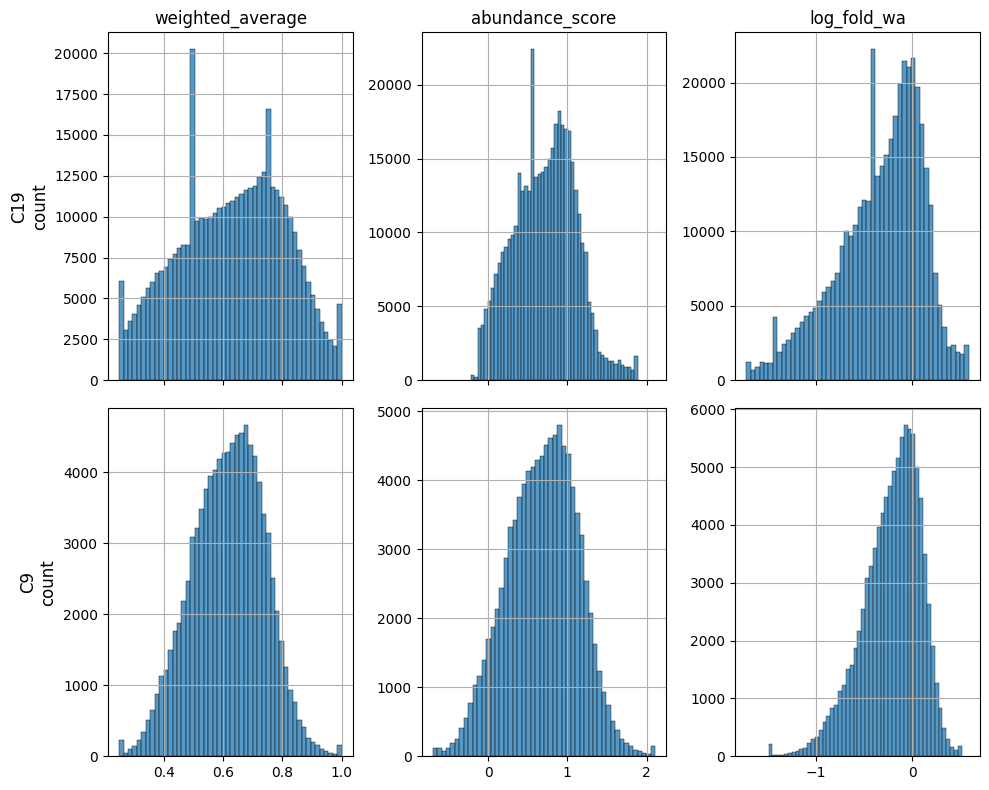

In [13]:
targets = ["weighted_average", "abundance_score", "log_fold_wa"]
fig, ax = plt.subplots(
    len(func_score_df.condition.unique()),
    len(targets),
    sharex="col",
    figsize=[10, 8]
)
for row, (condition, condition_df) in enumerate(func_score_df.groupby("condition")):
    for col, target in enumerate(targets):
        sns.histplot(condition_df, x=target, ax=ax[row, col], bins=50)
        ax[row, col].grid()
        ax[row, col].set_xlabel("")
        ax[row, col].set_ylabel("")
        if col == 0:
            ax[row, col].set_ylabel(f"{condition}\ncount", size=12)
        if row == 0:
            ax[row, col].set_title(target)
plt.tight_layout()
plt.show()

## Barcodes

First, we'll look at the number of barcodes per variant

In [14]:
for col, (condition, condition_df) in enumerate(func_score_df.groupby("condition")):
    vc = condition_df.aa_substitutions.value_counts()
    print(condition,'\n',vc.describe())

C19 
 count    8472.000000
mean       49.710458
std        64.122068
min         1.000000
25%        12.000000
50%        28.000000
75%        62.000000
max      1457.000000
Name: count, dtype: float64
C9 
 count    8308.000000
mean       11.780573
std        12.594819
min         1.000000
25%         4.000000
50%         8.000000
75%        14.000000
max       172.000000
Name: count, dtype: float64


In [15]:
list(range(0, 10, 2))

[0, 2, 4, 6, 8]

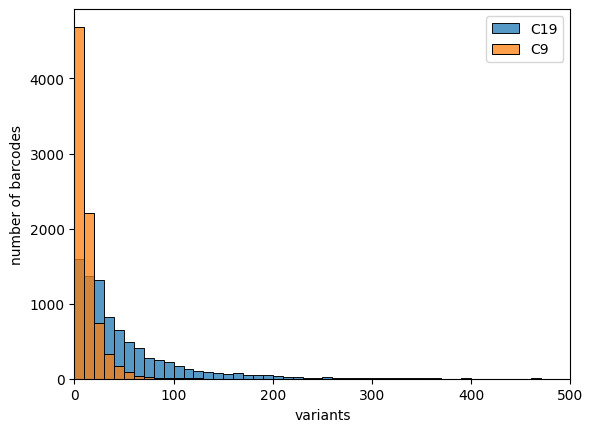

In [16]:
fig, ax = plt.subplots()
for col, (condition, condition_df) in enumerate(func_score_df.groupby("condition")):
    vc = condition_df.aa_substitutions.value_counts().reset_index()
    sns.histplot(vc, x="aa_substitutions", ax=ax, bins=range(0, 500, 10), label=condition)
    ax.set_ylabel("number of barcodes")
    ax.set_xlabel("variants")
    ax.set_xlim([0, 500])
    ax.legend()

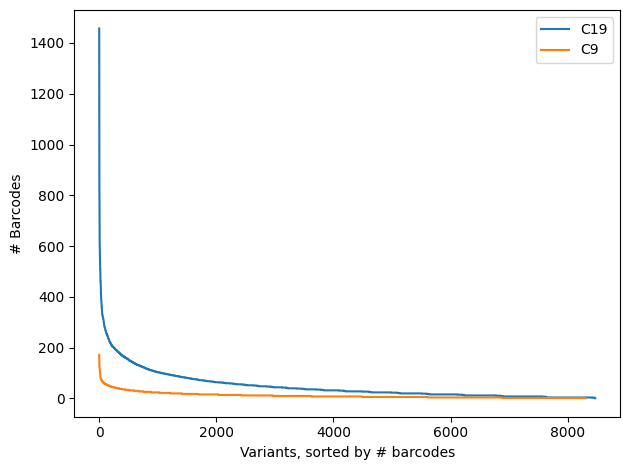

In [17]:
fig, ax = plt.subplots()
for col, (condition, condition_df) in enumerate(func_score_df.groupby("condition")):
    vc = condition_df.aa_substitutions.value_counts()
#     print(f"{condition} \n{vc[:5]}\n{vc[-5:]}")
    ax.plot(vc.values, label=condition)
    ax.set_ylabel("# Barcodes")
    ax.set_xlabel("Variants, sorted by # barcodes")
#     ax.set_title(condition)
ax.legend()
plt.tight_layout()
plt.show()

Next, let's look at the stoachasticity to expect by number of barcodes

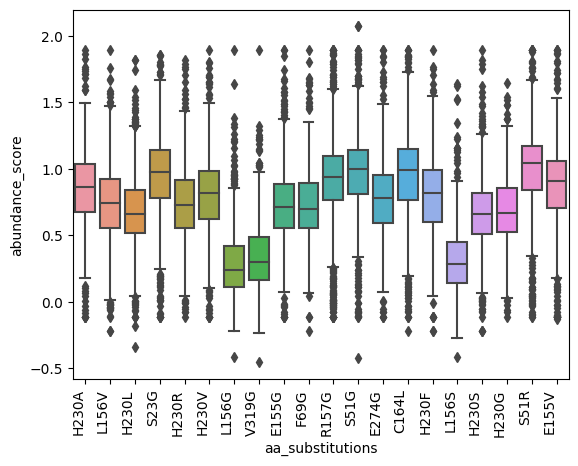

In [18]:
fig, ax = plt.subplots()
subs = func_score_df.aa_substitutions.value_counts()[:20].index
subs_fs = func_score_df.query(f"aa_substitutions.isin({list(subs)})")
sns.boxplot(subs_fs, x="aa_substitutions", y="abundance_score", ax=ax)
ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=90, ha='right')
plt.show()

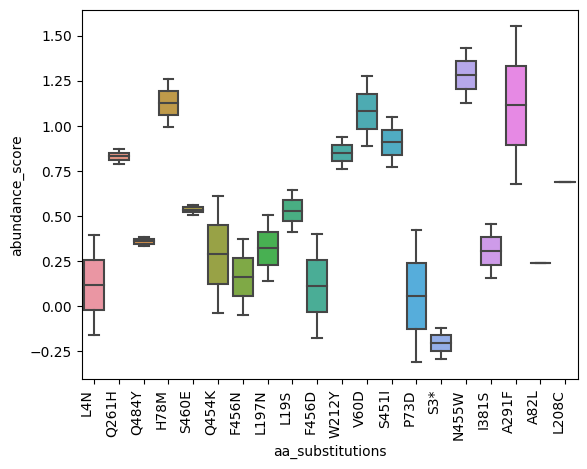

In [19]:
fig, ax = plt.subplots()
subs = func_score_df.aa_substitutions.value_counts()[-20:].index
subs_fs = func_score_df.query(f"aa_substitutions.isin({list(subs)})")
sns.boxplot(subs_fs, x="aa_substitutions", y="abundance_score", ax=ax)
ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=90, ha='right')
plt.show()

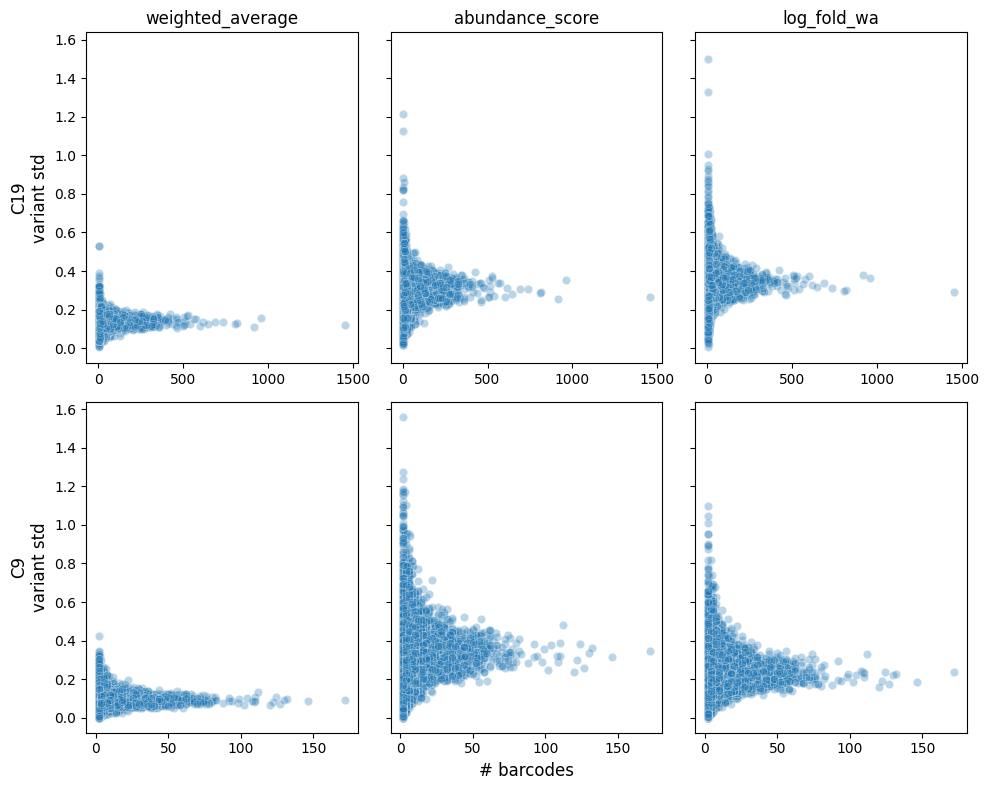

In [20]:
targets = ["weighted_average", "abundance_score", "log_fold_wa"]
fig, ax = plt.subplots(
    len(func_score_df.condition.unique()),
    len(targets),
    sharey=True,
    figsize=[10, 8]
)
for row, (condition, condition_df) in enumerate(func_score_df.groupby("condition")):
    for col, target in enumerate(targets):
        cv = condition_df.groupby("aa_substitutions").agg({"barcode":lambda x: len(x), target:onp.std})
        sns.scatterplot(cv,x="barcode", y=target, ax = ax[row, col], alpha=0.3)
        ax[row, col].set_xlabel("")
        ax[row, col].set_ylabel("")
        if col == 0:
            ax[row, col].set_ylabel(f"{condition}\nvariant std", size=12)
        if row == 0:
            ax[row, col].set_title(target)
        if row == 1 and col == 1:
            ax[row, col].set_xlabel("# barcodes", size=12)
plt.tight_layout()
plt.show()

# Prep `MultiDmsData` Objects for single homolog models

In [21]:
prep_params = {
    # pre-processing params
#     "scale_counts" : False,
#     "pseudocount" : 0.1,
#     "sample" : False,
#     "min_pre_counts" : 100,
#     "clip_target" : (-3.5, 2.5),
#     "trim" : False
}

In [22]:
datasets = pd.DataFrame()

Intantiate `MultiDmsData` Object

In [23]:
# targets = ["abundance_score", "log_fold_wa"]
for condition, condition_df in func_score_df.groupby("condition"):
    for collapse_barcodes in ['mean', False]:
        start = time.time()
        data = multidms.MultiDmsData(
            condition_df.rename({"abundance_score":"func_score"}, axis=1),
            reference = condition,
            collapse_identical_variants = collapse_barcodes,
            alphabet= multidms.AAS_WITHSTOP,
            verbose=False
        )
        end = time.time()
        prep_time = round(end-start)
        print(f"Finished, time: {prep_time}")
        data.condition_colors = {
            'C19': (0.0, 0.4470588235294118, 0.6980392156862745), 
            'C9': (0.0, 0.6196078431372549, 0.45098039215686275)
        }
        prep_params['conditions'] = tuple(condition_df.condition.unique())
        prep_params['collapse_barcodes'] = collapse_barcodes
        prep_params['target'] = target
        prep_params['time_to_prep'] = prep_time
        prep_params['reference'] = condition
        data_row = pd.Series(prep_params).to_frame().T
        data_row['data'] = data
        datasets = pd.concat([datasets, data_row], ignore_index=True)

INFO: Pandarallel will run on 32 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
Finished, time: 2
INFO: Pandarallel will run on 32 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
Finished, time: 33
INFO: Pandarallel will run on 32 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
Finished, time: 1
INFO: Pandarallel will run on 32 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
Finished, time: 8


In [24]:
datasets

conditions collapse_barcodes       target time_to_prep reference  \
0     (C19,)              mean  log_fold_wa            2       C19   
1     (C19,)             False  log_fold_wa           33       C19   
2      (C9,)              mean  log_fold_wa            1        C9   
3      (C9,)             False  log_fold_wa            8        C9   

                                                data  
0  <multidms.data.MultiDmsData object at 0x7f17f0...  
1  <multidms.data.MultiDmsData object at 0x7f17f0...  
2  <multidms.data.MultiDmsData object at 0x7f17f0...  
3  <multidms.data.MultiDmsData object at 0x7f17f0...

In [25]:
datasets.loc[1, "data"].variants_df

index replicate  sort             barcode  weighted_average  \
0            0      Rep2   1.0  AAAAAAAACTACGTTCCA          0.844684   
1            1      Rep2   1.0  AAAAAAAATCCTAGCCGT          0.563894   
2            2      Rep2   1.0  AAAAAAAATTTTGAAAGA          0.681836   
3            3      Rep2   1.0  AAAAAAACTATTGACTTC          0.751838   
4            4      Rep2   1.0  AAAAAAATACAGGTTAAT          0.304310   
...        ...       ...   ...                 ...               ...   
421142  439289      Rep3   2.0  TTTTTTTTACTAGGTCCA          0.516334   
421143  439290      Rep3   2.0  TTTTTTTTATCTCTCCCA          0.273961   
421144  439291      Rep3   2.0  TTTTTTTTCATTTTCTTC          0.500000   
421145  439292      Rep3   2.0  TTTTTTTTCTTCACAGAA          0.484294   
421146  439293      Rep3   2.0  TTTTTTTTTCTGCCTCTT          0.904984   

        total_reads      freq      type  med_nonsense     wt_wa  func_score  \
0               234  0.000008  missense      0.291621  0.826506    1.033983   
1               937  0.000039  missense      0.291621  0.826506    0.509032   
2               959  0.000038  missense      0.291621  0.826506    0.729530   
3               217  0.000008  missense      0.291621  0.826506    0.860404   
4               215  0.000017  nonsense      0.291621  0.826506    0.023724   
...             ...       ...       ...           ...       ...         ...   
421142          649  0.000026  missense      0.291848  0.666583    0.599054   
421143           80  0.000011  missense      0.291848  0.666583   -0.047731   
421144         1025  0.000019  missense      0.291848  0.666583    0.555464   
421145          908  0.000022  missense      0.291848  0.666583    0.513551   
421146          179  0.000028  missense      0.291848  0.666583    1.636183   

       aa_substitutions start  position end condition  log_fold_wa var_wrt_ref  
0                 S162R     S       162   R       C19     0.031385       S162R  
1                 D373R     D       373   R       C19    -0.551601       D373R  
2                 D360K     D       360   K       C19    -0.277602       D360K  
3                  L71G     L        71   G       C19    -0.136604        L71G  
4                 E274*     E       274   X       C19    -1.441484       E274*  
...                 ...   ...       ...  ..       ...          ...         ...  
421142            H251E     H       251   E       C19    -0.368480       H251E  
421143            Q184R     Q       184   R       C19    -1.282814       Q184R  
421144             L54R     L        54   R       C19    -0.414858        L54R  
421145            P427G     P       427   G       C19    -0.460904       P427G  
421146             L43M     L        43   M       C19     0.441107        L43M  

[421147 rows x 18 columns]

## Fit Single Homolog Models

In [26]:
models = pd.DataFrame()

In [27]:
fit_params = {
    'epistatic_model' : "Identity",
    'output_activation' : "Identity",
    'gamma_corrected' : False,
    'init_C_ref' : 1.0,
    'lock_C_ref' : 1.0,
    'warmup_beta':False,
    'save_model_at':[2000],
    'num_training_steps': 10,
    'iterations_per_step': 200,
    'tol':1e-6
}

Starting with collapsed barcodes, we expect these to fit perfectly.

In [28]:
for data_idx, data_row in datasets.query("collapse_barcodes == 'mean'").iterrows():
    start_t = time.time()
    new_fit_params = fit_params.copy()
    new_fit_params["init_C_ref"] = 1.0 if data_row.target == "abundance_score" else 0.0
    new_fit_params["lock_C_ref"] = 1.0 if data_row.target == "abundance_score" else 0.0
    model = multidms.utils.fit_wrapper(data_row.data, **new_fit_params)
    model['data_idx'] = data_idx
    models = pd.concat([models, model], ignore_index=True)

running:
{'PRNGKey': 0,
 'conditional_c': False,
 'data_idx': 0,
 'dataset': <multidms.data.MultiDmsData object at 0x7f17f0a7a9b0>,
 'epistatic_model': 'Identity',
 'gamma_corrected': False,
 'init_C_ref': 0.0,
 'iterations_per_step': 200,
 'lock_C_ref': 0.0,
 'lock_beta': False,
 'num_training_steps': 10,
 'output_activation': 'Identity',
 'save_model_at': [2000],
 'step_loss': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 'tol': 1e-06,
 'warmup_beta': False,
 'δ_huber': 1,
 'λ_lasso_shift': 2e-05,
 'λ_ridge_beta': 0,
 'λ_ridge_gamma': 0,
 'λ_ridge_shift': 0}
training_step 0/10, Loss: 0.04691802244718248, Time: 6 Seconds
training_step 1/10, Loss: 0.007233279339959753, Time: 2 Seconds
training_step 2/10, Loss: 0.001327824097772357, Time: 2 Seconds
training_step 3/10, Loss: 0.0006318389503957801, Time: 2 Seconds
training_step 4/10, Loss: 0.0006318389595026451, Time: 2 Seconds
training_step 5/10, Loss: 0.0006318389686084939, Time: 2 Seconds
training_step 6/10, Loss: 0.000631838977713

In [29]:
models

dataset δ_huber λ_lasso_shift  \
0  <multidms.data.MultiDmsData object at 0x7f17f0...       1       0.00002   
1  <multidms.data.MultiDmsData object at 0x7f17f0...       1       0.00002   

  λ_ridge_beta λ_ridge_shift λ_ridge_gamma  data_idx epistatic_model  \
0            0             0             0         0        Identity   
1            0             0             0         2        Identity   

  output_activation lock_beta  ... conditional_c init_C_ref warmup_beta  \
0          Identity     False  ...         False        0.0       False   
1          Identity     False  ...         False        0.0       False   

        tol num_training_steps iterations_per_step save_model_at PRNGKey  \
0  0.000001                 10                 200        [2000]       0   
1  0.000001                 10                 200        [2000]       0   

                                           step_loss  \
0  [0.04691802244718248, 0.007233279339959753, 0....   
1  [0.04310297781211156, 0.006536130737780874, 0....   

                                          model_2000  
0  <multidms.model.MultiDmsModel object at 0x7f17...  
1  <multidms.model.MultiDmsModel object at 0x7f17...  

[2 rows x 22 columns]

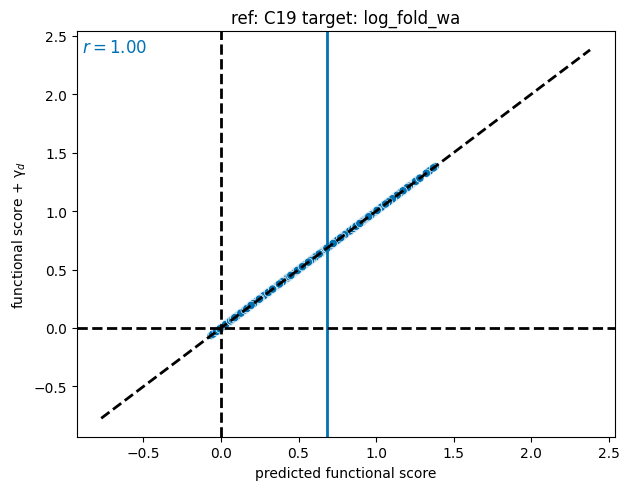

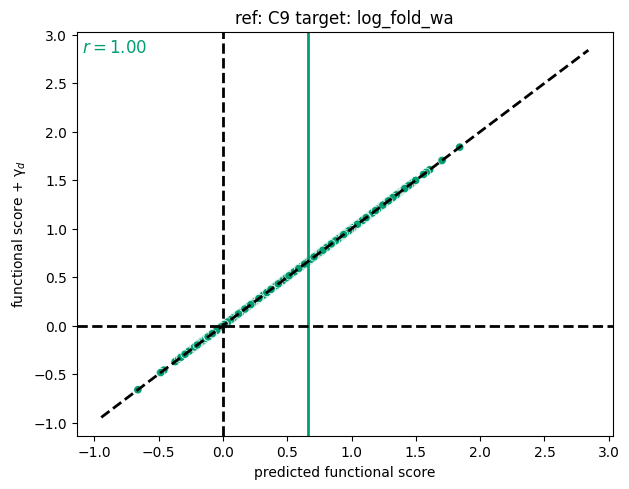

In [30]:
for model_idx, model_row in models.iterrows():
    fig, ax = plt.subplots()
    model_row.model_2000.plot_pred_accuracy(ax=ax, show=False, legend=False)
    ax.set_title(f"ref: {model_row.model_2000.data.reference} target: {datasets.loc[model_row.data_idx, 'target']}")
    plt.show()

## Fit Single Homolog Models (non-collapsed barcodes)

In [31]:
for data_idx, data_row in datasets.query("collapse_barcodes == False").iterrows():
    start_t = time.time()
    new_fit_params = fit_params.copy()
    new_fit_params["init_C_ref"] = 1.0 if data_row.target == "abundance_score" else 0.0
    new_fit_params["lock_C_ref"] = 1.0 if data_row.target == "abundance_score" else 0.0
    model = multidms.utils.fit_wrapper(data_row.data, **new_fit_params)
    model['data_idx'] = data_idx
    models = pd.concat([models, model], ignore_index=True)

running:
{'PRNGKey': 0,
 'conditional_c': False,
 'data_idx': 0,
 'dataset': <multidms.data.MultiDmsData object at 0x7f17f0855db0>,
 'epistatic_model': 'Identity',
 'gamma_corrected': False,
 'init_C_ref': 0.0,
 'iterations_per_step': 200,
 'lock_C_ref': 0.0,
 'lock_beta': False,
 'num_training_steps': 10,
 'output_activation': 'Identity',
 'save_model_at': [2000],
 'step_loss': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 'tol': 1e-06,
 'warmup_beta': False,
 'δ_huber': 1,
 'λ_lasso_shift': 2e-05,
 'λ_ridge_beta': 0,
 'λ_ridge_gamma': 0,
 'λ_ridge_shift': 0}
training_step 0/10, Loss: 0.10302980930886883, Time: 6 Seconds
training_step 1/10, Loss: 0.07407088021071925, Time: 4 Seconds
training_step 2/10, Loss: 0.0636223094064795, Time: 4 Seconds
training_step 3/10, Loss: 0.05826082252090494, Time: 4 Seconds
training_step 4/10, Loss: 0.05520385264062016, Time: 4 Seconds
training_step 5/10, Loss: 0.05329372782377913, Time: 4 Seconds
training_step 6/10, Loss: 0.052016655010357335, Time

In [32]:
models

dataset δ_huber λ_lasso_shift  \
0  <multidms.data.MultiDmsData object at 0x7f17f0...       1       0.00002   
1  <multidms.data.MultiDmsData object at 0x7f17f0...       1       0.00002   
2  <multidms.data.MultiDmsData object at 0x7f17f0...       1       0.00002   
3  <multidms.data.MultiDmsData object at 0x7f17f0...       1       0.00002   

  λ_ridge_beta λ_ridge_shift λ_ridge_gamma  data_idx epistatic_model  \
0            0             0             0         0        Identity   
1            0             0             0         2        Identity   
2            0             0             0         1        Identity   
3            0             0             0         3        Identity   

  output_activation lock_beta  ... conditional_c init_C_ref warmup_beta  \
0          Identity     False  ...         False        0.0       False   
1          Identity     False  ...         False        0.0       False   
2          Identity     False  ...         False        0.0       False   
3          Identity     False  ...         False        0.0       False   

        tol num_training_steps iterations_per_step save_model_at PRNGKey  \
0  0.000001                 10                 200        [2000]       0   
1  0.000001                 10                 200        [2000]       0   
2  0.000001                 10                 200        [2000]       0   
3  0.000001                 10                 200        [2000]       0   

                                           step_loss  \
0  [0.04691802244718248, 0.007233279339959753, 0....   
1  [0.04310297781211156, 0.006536130737780874, 0....   
2  [0.10302980930886883, 0.07407088021071925, 0.0...   
3  [0.10748074957450092, 0.07695096003194114, 0.0...   

                                          model_2000  
0  <multidms.model.MultiDmsModel object at 0x7f17...  
1  <multidms.model.MultiDmsModel object at 0x7f17...  
2  <multidms.model.MultiDmsModel object at 0x7f17...  
3  <multidms.model.MultiDmsModel object at 0x7f17...  

[4 rows x 22 columns]

In [33]:
for model_idx, model_row in models.loc[2:].iterrows():
    if datasets.loc[model_row.data_idx, "target"] == "log_fold_wa": continue
    fig, ax = plt.subplots()
    model_row.model_2000.plot_pred_accuracy(ax=ax, show=False, legend=False, alpha=0.003)
    ax.set_title(f"ref: {model_row.model_2000.data.reference} target: {datasets.loc[model_row.data_idx, 'target']}")
    ax.set_ylim([-.5, 2.2])
    ax.set_xlim([-0.5, 1.5])
    plt.show()

## Fit individual replicate 2-homolog models

In [34]:

for replicate, replicate_df in func_score_df.groupby("replicate"):
    if replicate == "Rep1": continue
        
    data = multidms.MultiDmsData(
        replicate_df.rename({"abundance_score":"func_score"}, axis=1),
        reference = "C9",
        collapse_identical_variants = False,
        alphabet= multidms.AAS_WITHSTOP,
        verbose=True
    )


    data.condition_colors = {
        'C19': (0.0, 0.4470588235294118, 0.6980392156862745), 
        'C9': (0.0, 0.6196078431372549, 0.45098039215686275)
    }
    
    fit_params = {
        'epistatic_model' : "Identity",
        'output_activation' : "Identity",
        'lock_C_ref' : 1.,
        'init_C_ref' : 1.,
        'gamma_corrected' : False,
        'warmup_beta':False,
        'save_model_at':[10000],
        'num_training_steps': 10,
        'iterations_per_step': 1000,
        'tol' : 1e-5,
        'λ_lasso_shift' : 1e-5,
        'λ_ridge_beta' : 1e-6
    }
    start_t = time.time()
    fit = multidms.utils.fit_wrapper(data, **fit_params)
    fit["replicate"] = replicate
    fit["target"] = target

    models = pd.concat([models, fit], ignore_index=True)
    end_t = time.time()
    print(f"FINISHED total time: {round(end_t - start_t)} seconds")

print(f"Done")

inferring site map for C19
inferring site map for C9
INFO: Pandarallel will run on 32 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
Converting mutations for C19


Converting mutations for C9
is reference, skipping
running:
{'PRNGKey': 0,
 'conditional_c': False,
 'data_idx': 0,
 'dataset': <multidms.data.MultiDmsData object at 0x7f029d4e52a0>,
 'epistatic_model': 'Identity',
 'gamma_corrected': False,
 'init_C_ref': 1.0,
 'iterations_per_step': 1000,
 'lock_C_ref': 1.0,
 'lock_beta': False,
 'num_training_steps': 10,
 'output_activation': 'Identity',
 'save_model_at': [10000],
 'step_loss': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 'tol': 1e-05,
 'warmup_beta': False,
 'δ_huber': 1,
 'λ_lasso_shift': 1e-05,
 'λ_ridge_beta': 1e-06,
 'λ_ridge_gamma': 0,
 'λ_ridge_shift': 0}
training_step 0/10, Loss: 0.32188449672293357, Time: 56 Seconds
training_step 1/10, Loss: 0.21991560457582682, Time: 51 Seconds
training_step 2/10, Loss: 0.17363594802031046, Time: 51 Seconds
training_step 3/10, Loss: 0.14716076365288258, Time: 51 Seconds
training_step 4/10, Loss: 0.13036437911075757, Time: 51 Seconds
training_step 5/10, Loss: 0.11900446689548132, Time:

Converting mutations for C9
is reference, skipping
running:
{'PRNGKey': 0,
 'conditional_c': False,
 'data_idx': 0,
 'dataset': <multidms.data.MultiDmsData object at 0x7f029d4e4b80>,
 'epistatic_model': 'Identity',
 'gamma_corrected': False,
 'init_C_ref': 1.0,
 'iterations_per_step': 1000,
 'lock_C_ref': 1.0,
 'lock_beta': False,
 'num_training_steps': 10,
 'output_activation': 'Identity',
 'save_model_at': [10000],
 'step_loss': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 'tol': 1e-05,
 'warmup_beta': False,
 'δ_huber': 1,
 'λ_lasso_shift': 1e-05,
 'λ_ridge_beta': 1e-06,
 'λ_ridge_gamma': 0,
 'λ_ridge_shift': 0}
training_step 0/10, Loss: 0.3457296110652192, Time: 55 Seconds
training_step 1/10, Loss: 0.2484234800550148, Time: 51 Seconds
training_step 2/10, Loss: 0.20552402753010157, Time: 51 Seconds
training_step 3/10, Loss: 0.18072165462935125, Time: 51 Seconds
training_step 4/10, Loss: 0.16487422125514006, Time: 51 Seconds
training_step 5/10, Loss: 0.1541079798257474, Time: 51

TODO plot correlation

In [35]:
# fit_dict = {row.replicate:row.model_20000 for _, row in df.iterrows()}
# combined_rep_mut_df = multidms.utils.combine_replicate_muts(fit_dict, times_seen_threshold=10)
# fig, ax = plt.subplots()
# sns.scatterplot(combined_rep_mut_df, x="Rep2_S_C19", y="Rep3_S_C19", ax =ax)
# plt.show()

## Train model on all replicates, for 20K iterations

In [36]:
data = multidms.MultiDmsData(
    func_score_df.query("replicate != 'Rep1'").rename({"abundance_score":"func_score"}, axis=1),
    reference = "C9",
    collapse_identical_variants = False,
    alphabet= multidms.AAS_WITHSTOP,
    verbose=True
)

data.condition_colors = {
    'C19': (0.0, 0.4470588235294118, 0.6980392156862745), 
    'C9': (0.0, 0.6196078431372549, 0.45098039215686275)
}
fit_params = {
    'epistatic_model' : "Identity",
    'output_activation' : "Identity",
    'lock_C_ref' : 1.0,
    'init_C_ref' : 1.0,
    'gamma_corrected' : False,
    'warmup_beta':False,
    'save_model_at':[20000],
    'num_training_steps': 10,
    'iterations_per_step': 2000,
    'tol' : 1e-5,
    'λ_lasso_shift' : 1e-5,
    'λ_ridge_beta' : 0
}
start_t = time.time()
fit = multidms.utils.fit_wrapper(data, **fit_params)
fit["replicate"] = replicate
fit["target"] = target

models = pd.concat([models, fit], ignore_index=True)
end_t = time.time()
print(f"FINISHED total time: {round(end_t - start_t)} seconds")

print(f"Done")

inferring site map for C19
inferring site map for C9
INFO: Pandarallel will run on 32 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
Converting mutations for C19


Converting mutations for C9
is reference, skipping
running:
{'PRNGKey': 0,
 'conditional_c': False,
 'data_idx': 0,
 'dataset': <multidms.data.MultiDmsData object at 0x7f17eda49690>,
 'epistatic_model': 'Identity',
 'gamma_corrected': False,
 'init_C_ref': 1.0,
 'iterations_per_step': 2000,
 'lock_C_ref': 1.0,
 'lock_beta': False,
 'num_training_steps': 10,
 'output_activation': 'Identity',
 'save_model_at': [20000],
 'step_loss': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 'tol': 1e-05,
 'warmup_beta': False,
 'δ_huber': 1,
 'λ_lasso_shift': 1e-05,
 'λ_ridge_beta': 0,
 'λ_ridge_gamma': 0,
 'λ_ridge_shift': 0}
training_step 0/10, Loss: 0.1637770276588679, Time: 196 Seconds
training_step 1/10, Loss: 0.12576501656855188, Time: 191 Seconds
training_step 2/10, Loss: 0.11452508226416007, Time: 192 Seconds
training_step 3/10, Loss: 0.10967199100596506, Time: 192 Seconds
training_step 4/10, Loss: 0.10723713123647925, Time: 194 Seconds
training_step 5/10, Loss: 0.10589545472191354, Time:

In [38]:
models

dataset δ_huber λ_lasso_shift  \
0  <multidms.data.MultiDmsData object at 0x7f17f0...       1       0.00002   
1  <multidms.data.MultiDmsData object at 0x7f17f0...       1       0.00002   
2  <multidms.data.MultiDmsData object at 0x7f17f0...       1       0.00002   
3  <multidms.data.MultiDmsData object at 0x7f17f0...       1       0.00002   
4  <multidms.data.MultiDmsData object at 0x7f029d...       1       0.00001   
5  <multidms.data.MultiDmsData object at 0x7f029d...       1       0.00001   
6  <multidms.data.MultiDmsData object at 0x7f17ed...       1       0.00001   

  λ_ridge_beta λ_ridge_shift λ_ridge_gamma data_idx epistatic_model  \
0            0             0             0        0        Identity   
1            0             0             0        2        Identity   
2            0             0             0        1        Identity   
3            0             0             0        3        Identity   
4     0.000001             0             0        0        Identity   
5     0.000001             0             0        0        Identity   
6            0             0             0        0        Identity   

  output_activation lock_beta  ... num_training_steps iterations_per_step  \
0          Identity     False  ...                 10                 200   
1          Identity     False  ...                 10                 200   
2          Identity     False  ...                 10                 200   
3          Identity     False  ...                 10                 200   
4          Identity     False  ...                 10                1000   
5          Identity     False  ...                 10                1000   
6          Identity     False  ...                 10                2000   

  save_model_at PRNGKey                                          step_loss  \
0        [2000]       0  [0.04691802244718248, 0.007233279339959753, 0....   
1        [2000]       0  [0.04310297781211156, 0.006536130737780874, 0....   
2        [2000]       0  [0.10302980930886883, 0.07407088021071925, 0.0...   
3        [2000]       0  [0.10748074957450092, 0.07695096003194114, 0.0...   
4       [10000]       0  [0.3218844967229336, 0.21991560457582682, 0.17...   
5       [10000]       0  [0.3457296110652192, 0.2484234800550148, 0.205...   
6       [20000]       0  [0.1637770276588679, 0.12576501656855188, 0.11...   

                                          model_2000  \
0  <multidms.model.MultiDmsModel object at 0x7f17...   
1  <multidms.model.MultiDmsModel object at 0x7f17...   
2  <multidms.model.MultiDmsModel object at 0x7f17...   
3  <multidms.model.MultiDmsModel object at 0x7f17...   
4                                                NaN   
5                                                NaN   
6                                                NaN   

                                         model_10000 replicate       target  \
0                                                NaN       NaN          NaN   
1                                                NaN       NaN          NaN   
2                                                NaN       NaN          NaN   
3                                                NaN       NaN          NaN   
4  <multidms.model.MultiDmsModel object at 0x7f17...      Rep2  log_fold_wa   
5  <multidms.model.MultiDmsModel object at 0x7f18...      Rep3  log_fold_wa   
6                                                NaN      Rep3  log_fold_wa   

                                         model_20000  
0                                                NaN  
1                                                NaN  
2                                                NaN  
3                                                NaN  
4                                                NaN  
5                                                NaN  
6  <multidms.model.MultiDmsModel object at 0x7f18...  

[7 rows x 26 columns]

In [39]:
full_data_fit = models.loc[6, "model_20000"]

In [40]:
full_data_fit.mutations_df

mutation wts  sites muts  times_seen_C19  times_seen_C9         β  \
0         D2A   D      2    A            36.0           18.0 -0.215538   
1         D2C   D      2    C            16.0            6.0  0.043175   
2         D2E   D      2    E            27.0           16.0 -0.034408   
3         D2F   D      2    F            14.0            6.0 -0.198279   
4         D2G   D      2    G           235.0           50.0 -0.110028   
...       ...  ..    ...  ...             ...            ...       ...   
9390    V490R   V    490    R             4.0           22.0 -0.000173   
9391    V490S   V    490    S             8.0           17.0 -0.032291   
9392    V490T   V    490    T             4.0            4.0 -0.019776   
9393    V490W   V    490    W             0.0            2.0 -0.015842   
9394    V490Y   V    490    Y             0.0            2.0 -0.149761   

         S_C19  
0     0.000000  
1    -0.000000  
2     0.000000  
3     0.000000  
4     0.058723  
...        ...  
9390  0.000000  
9391 -0.000000  
9392  0.000000  
9393  0.000000  
9394  0.000000  

[9395 rows x 8 columns]

In [41]:
full_data_fit.mut_shift_plot(include_beta=False)

/home/jgallowa/miniconda3/envs/multidms_toml/lib/python3.10/site-packages/altair/utils/core.py:317: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col_name, dtype in df.dtypes.iteritems():


alt.VConcatChart(...)

In [61]:
md = full_data_fit.mutations_df

In [69]:
full_data_fit.data.non_identical_sites['C19'].to_csv("non_identical_sites")

In [62]:
md

mutation wts  sites muts  times_seen_C19  times_seen_C9         β  \
0         D2A   D      2    A            36.0           18.0 -0.215538   
1         D2C   D      2    C            16.0            6.0  0.043174   
2         D2E   D      2    E            27.0           16.0 -0.034409   
3         D2F   D      2    F            14.0            6.0 -0.198279   
4         D2G   D      2    G           235.0           50.0 -0.110028   
...       ...  ..    ...  ...             ...            ...       ...   
9390    V490R   V    490    R             4.0           22.0 -0.000174   
9391    V490S   V    490    S             8.0           17.0 -0.032291   
9392    V490T   V    490    T             4.0            4.0 -0.019791   
9393    V490W   V    490    W             0.0            2.0 -0.015859   
9394    V490Y   V    490    Y             0.0            2.0 -0.149729   

         S_C19  
0     0.000000  
1    -0.000000  
2     0.000000  
3     0.000000  
4     0.058722  
...        ...  
9390  0.000000  
9391 -0.000000  
9392  0.000000  
9393  0.000000  
9394  0.000000  

[9395 rows x 8 columns]

In [63]:
md[md.wts == md.muts]

Empty DataFrame
Columns: [mutation, wts, sites, muts, times_seen_C19, times_seen_C9, β, S_C19]
Index: []

In [60]:
full_data_fit.mutations_df.to_csv("mutations_df.csv", index=False)

In [ ]:
fig, ax = plt.subplots(figsize=)


Plot:
1. accuracy
2. distributions of shifts
3. distributions of shifts at non identical
4. Sum of shifts by site
5. altair interactive

In [44]:
data = multidms.MultiDmsData(
    func_score_df.query("replicate != 'Rep1'").rename({"abundance_score":"func_score"}, axis=1),
    reference = "C19",
    collapse_identical_variants = False,
    alphabet= multidms.AAS_WITHSTOP,
    verbose=True
)

data.condition_colors = {
    'C19': (0.0, 0.4470588235294118, 0.6980392156862745), 
    'C9': (0.0, 0.6196078431372549, 0.45098039215686275)
}
fit_params = {
    'epistatic_model' : "Identity",
    'output_activation' : "Identity",
    'lock_C_ref' : 1.0,
    'init_C_ref' : 1.0,
    'gamma_corrected' : False,
    'warmup_beta':False,
    'save_model_at':[20000],
    'num_training_steps': 10,
    'iterations_per_step': 2000,
    'tol' : 1e-5,
    'λ_lasso_shift' : 1e-5,
    'λ_ridge_beta' : 0
}
start_t = time.time()
fit = multidms.utils.fit_wrapper(data, **fit_params)
fit["replicate"] = replicate
fit["target"] = target

models = pd.concat([models, fit], ignore_index=True)
end_t = time.time()
print(f"FINISHED total time: {round(end_t - start_t)} seconds")

print(f"Done")

inferring site map for C19
inferring site map for C9
INFO: Pandarallel will run on 32 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
Converting mutations for C19
is reference, skipping
Converting mutations for C9


running:
{'PRNGKey': 0,
 'conditional_c': False,
 'data_idx': 0,
 'dataset': <multidms.data.MultiDmsData object at 0x7f17f2a79fc0>,
 'epistatic_model': 'Identity',
 'gamma_corrected': False,
 'init_C_ref': 1.0,
 'iterations_per_step': 2000,
 'lock_C_ref': 1.0,
 'lock_beta': False,
 'num_training_steps': 10,
 'output_activation': 'Identity',
 'save_model_at': [20000],
 'step_loss': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 'tol': 1e-05,
 'warmup_beta': False,
 'δ_huber': 1,
 'λ_lasso_shift': 1e-05,
 'λ_ridge_beta': 0,
 'λ_ridge_gamma': 0,
 'λ_ridge_shift': 0}
training_step 0/10, Loss: 0.15746150696032568, Time: 52 Seconds
training_step 1/10, Loss: 0.12314051466537017, Time: 48 Seconds
training_step 2/10, Loss: 0.11307124285745157, Time: 48 Seconds
training_step 3/10, Loss: 0.1088073275537031, Time: 48 Seconds
training_step 4/10, Loss: 0.10665536901993286, Time: 48 Seconds
training_step 5/10, Loss: 0.10544274874387395, Time: 47 Seconds
training_step 6/10, Loss: 0.1047147307891459

In [45]:
models

dataset δ_huber λ_lasso_shift  \
0  <multidms.data.MultiDmsData object at 0x7f17f0...       1       0.00002   
1  <multidms.data.MultiDmsData object at 0x7f17f0...       1       0.00002   
2  <multidms.data.MultiDmsData object at 0x7f17f0...       1       0.00002   
3  <multidms.data.MultiDmsData object at 0x7f17f0...       1       0.00002   
4  <multidms.data.MultiDmsData object at 0x7f029d...       1       0.00001   
5  <multidms.data.MultiDmsData object at 0x7f029d...       1       0.00001   
6  <multidms.data.MultiDmsData object at 0x7f17ed...       1       0.00001   
7  <multidms.data.MultiDmsData object at 0x7f17f2...       1       0.00001   

  λ_ridge_beta λ_ridge_shift λ_ridge_gamma data_idx epistatic_model  \
0            0             0             0        0        Identity   
1            0             0             0        2        Identity   
2            0             0             0        1        Identity   
3            0             0             0        3        Identity   
4     0.000001             0             0        0        Identity   
5     0.000001             0             0        0        Identity   
6            0             0             0        0        Identity   
7            0             0             0        0        Identity   

  output_activation lock_beta  ... num_training_steps iterations_per_step  \
0          Identity     False  ...                 10                 200   
1          Identity     False  ...                 10                 200   
2          Identity     False  ...                 10                 200   
3          Identity     False  ...                 10                 200   
4          Identity     False  ...                 10                1000   
5          Identity     False  ...                 10                1000   
6          Identity     False  ...                 10                2000   
7          Identity     False  ...                 10                2000   

  save_model_at PRNGKey                                          step_loss  \
0        [2000]       0  [0.04691802244718248, 0.007233279339959753, 0....   
1        [2000]       0  [0.04310297781211156, 0.006536130737780874, 0....   
2        [2000]       0  [0.10302980930886883, 0.07407088021071925, 0.0...   
3        [2000]       0  [0.10748074957450092, 0.07695096003194114, 0.0...   
4       [10000]       0  [0.3218844967229336, 0.21991560457582682, 0.17...   
5       [10000]       0  [0.3457296110652192, 0.2484234800550148, 0.205...   
6       [20000]       0  [0.1637770276588679, 0.12576501656855188, 0.11...   
7       [20000]       0  [0.15746150696032568, 0.12314051466537017, 0.1...   

                                          model_2000  \
0  <multidms.model.MultiDmsModel object at 0x7f17...   
1  <multidms.model.MultiDmsModel object at 0x7f17...   
2  <multidms.model.MultiDmsModel object at 0x7f17...   
3  <multidms.model.MultiDmsModel object at 0x7f17...   
4                                                NaN   
5                                                NaN   
6                                                NaN   
7                                                NaN   

                                         model_10000 replicate       target  \
0                                                NaN       NaN          NaN   
1                                                NaN       NaN          NaN   
2                                                NaN       NaN          NaN   
3                                                NaN       NaN          NaN   
4  <multidms.model.MultiDmsModel object at 0x7f17...      Rep2  log_fold_wa   
5  <multidms.model.MultiDmsModel object at 0x7f18...      Rep3  log_fold_wa   
6                                                NaN      Rep3  log_fold_wa   
7                                                NaN      Rep3  log_fold_wa   

                                         model_20000  
0                                

In [46]:
C19_full_data_fit = models.loc[7, "model_20000"]
# C19_full_data_fit.mutations_df.to_csv("C19ref_mutations_df.csv", index=False)
chart = C19_full_data_fit.mut_shift_plot(include_beta=False)
# chart.save("../results/Rep2_Rep3_C19_ref_mut_shift_plot.html")
chart

/home/jgallowa/miniconda3/envs/multidms_toml/lib/python3.10/site-packages/altair/utils/core.py:317: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col_name, dtype in df.dtypes.iteritems():


alt.VConcatChart(...)

## Sweep of lasso params

In [112]:
models = pd.DataFrame()

In [103]:
data = multidms.MultiDmsData(
    func_score_df.query("replicate != 'Rep1'").rename({"abundance_score":"func_score"}, axis=1),
    reference = "C19",
    collapse_identical_variants = False,
    alphabet= multidms.AAS_WITHSTOP,
    verbose=True
)

inferring site map for C19
inferring site map for C9
INFO: Pandarallel will run on 32 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
Converting mutations for C19
is reference, skipping
Converting mutations for C9


In [113]:
for lasso in [1e-3,1e-4,1e-5,1e-6,1e-7]:

    data.condition_colors = {
        'C19': (0.0, 0.4470588235294118, 0.6980392156862745), 
        'C9': (0.0, 0.6196078431372549, 0.45098039215686275)
    }
    fit_params = {
        'epistatic_model' : "Identity",
        'output_activation' : "Identity",
        'lock_C_ref' : 1.0,
        'init_C_ref' : 1.0,
        'gamma_corrected' : False,
        'warmup_beta':False,
        'save_model_at':[20000],
        'num_training_steps': 10,
        'iterations_per_step': 2000,
        'tol' : 1e-5,
        'λ_lasso_shift' : lasso,
        'λ_ridge_beta' : 0
    }
    start_t = time.time()
    fit = multidms.utils.fit_wrapper(data, **fit_params)
    fit["replicate"] = replicate
    fit["target"] = "abundance_score"

    models = pd.concat([models, fit], ignore_index=True)
    end_t = time.time()
    print(f"FINISHED total time: {round(end_t - start_t)} seconds")

    print(f"Done")

running:
{'PRNGKey': 0,
 'conditional_c': False,
 'data_idx': 0,
 'dataset': <multidms.data.MultiDmsData object at 0x7f000470ba60>,
 'epistatic_model': 'Identity',
 'gamma_corrected': False,
 'init_C_ref': 1.0,
 'iterations_per_step': 2000,
 'lock_C_ref': 1.0,
 'lock_beta': False,
 'num_training_steps': 10,
 'output_activation': 'Identity',
 'save_model_at': [20000],
 'step_loss': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 'tol': 1e-05,
 'warmup_beta': False,
 'δ_huber': 1,
 'λ_lasso_shift': 0.001,
 'λ_ridge_beta': 0,
 'λ_ridge_gamma': 0,
 'λ_ridge_shift': 0}
training_step 0/10, Loss: 0.14120030483307966, Time: 51 Seconds
training_step 1/10, Loss: 0.11347927285598562, Time: 48 Seconds
training_step 2/10, Loss: 0.10918832885377001, Time: 48 Seconds
training_step 3/10, Loss: 0.107764595673361, Time: 48 Seconds
training_step 4/10, Loss: 0.10717013601548565, Time: 48 Seconds
training_step 5/10, Loss: 0.10687079856743717, Time: 48 Seconds
training_step 6/10, Loss: 0.10670665886882524

In [114]:
mut_df = multidms.utils.combine_replicate_muts(
    {
        f"lasso_{row.λ_lasso_shift}" : row.model_20000
        for idx, row in models.iterrows()   
    }
)

In [115]:
mut_df

wts  sites muts  lasso_0.001_β  lasso_0.0001_β  lasso_1e-05_β  \
mutation                                                                 
D2A        D      2    A      -0.190741       -0.190529      -0.180742   
D2C        D      2    C       0.066343        0.066575       0.076515   
D2E        D      2    E      -0.009209       -0.008982       0.001418   
D2F        D      2    F      -0.174728       -0.174480      -0.163907   
D2G        D      2    G      -0.056749       -0.056611      -0.035240   
...       ..    ...  ...            ...             ...            ...   
V490N      V    490    N      -0.022028       -0.021697      -0.007752   
V490P      V    490    P      -0.330680       -0.330408      -0.262310   
V490R      V    490    R       0.028086        0.028391       0.038298   
V490S      V    490    S      -0.004720       -0.004428       0.008772   
V490T      V    490    T      -0.025914       -0.025115       0.440487   

          lasso_1e-06_β  lasso_1e-07_β     avg_β  lasso_0.001_S_C9  \
mutation                                                             
D2A           -0.107039      -0.096114 -0.153033              -0.0   
D2C            0.008601      -0.007437  0.042120               0.0   
D2E           -0.022371      -0.034382 -0.014705              -0.0   
D2F           -0.149246      -0.135760 -0.159624              -0.0   
D2G           -0.019032      -0.017292 -0.036985              -0.0   
...                 ...            ...       ...               ...   
V490N         -0.172099      -0.201517 -0.085019              -0.0   
V490P         -0.036554      -0.013336 -0.194658              -0.0   
V490R         -0.287438      -0.317795 -0.102091              -0.0   
V490S         -0.142843      -0.166794 -0.062003               0.0   
V490T          0.736614       0.766592  0.378533              -0.0   

          lasso_0.0001_S_C9  lasso_1e-05_S_C9  lasso_1e-06_S_C9  \
mutation                                                          
D2A                    -0.0         -0.000000         -0.087150   
D2C                     0.0          0.000000          0.139156   
D2E                    -0.0         -0.000000          0.047072   
D2F                    -0.0         -0.000000         -0.000000   
D2G                    -0.0         -0.031129         -0.043836   
...                     ...               ...               ...   
V490N                  -0.0         -0.000000          0.178553   
V490P                  -0.0         -0.039680         -0.318085   
V490R                  -0.0         -0.001378          0.347346   
V490S                   0.0          0.000000          0.182300   
V490T                  -0.0         -0.431903         -0.845004   

          lasso_1e-07_S_C9  avg_S_C9  
mutation                              
D2A              -0.096901 -0.036810  
D2C               0.173015  0.062434  
D2E               0.070269  0.023468  
D2F              -0.013202 -0.002640  
D2G              -0.041198 -0.023233  
...                    ...       ...  
V490N             0.219351  0.079581  
V490P            -0.342795 -0.140112  
V490R             0.386698  0.146533  
V490S             0.216236  0.079707  
V490T            -0.883358 -0.432053  

[6198 rows x 15 columns]

In [116]:
from scipy.stats import pearsonr
import matplotlib.pyplot as plt 

def corrfunc(x, y, ax=None, **kws):
    """Plot the correlation coefficient in the top left hand corner of a plot."""
    both_non_zero = onp.logical_and(x!=0, y!=0)
#     print(both_non_zero)
    if len(both_non_zero[both_non_zero]) <= 2:
        r = 0
    else:
        r, _ = pearsonr(x[both_non_zero], y[both_non_zero])
    ax = ax or plt.gca()
    ax.annotate(f'ρ = {r:.2f}', xy=(.1, .9), xycoords=ax.transAxes, size=15)

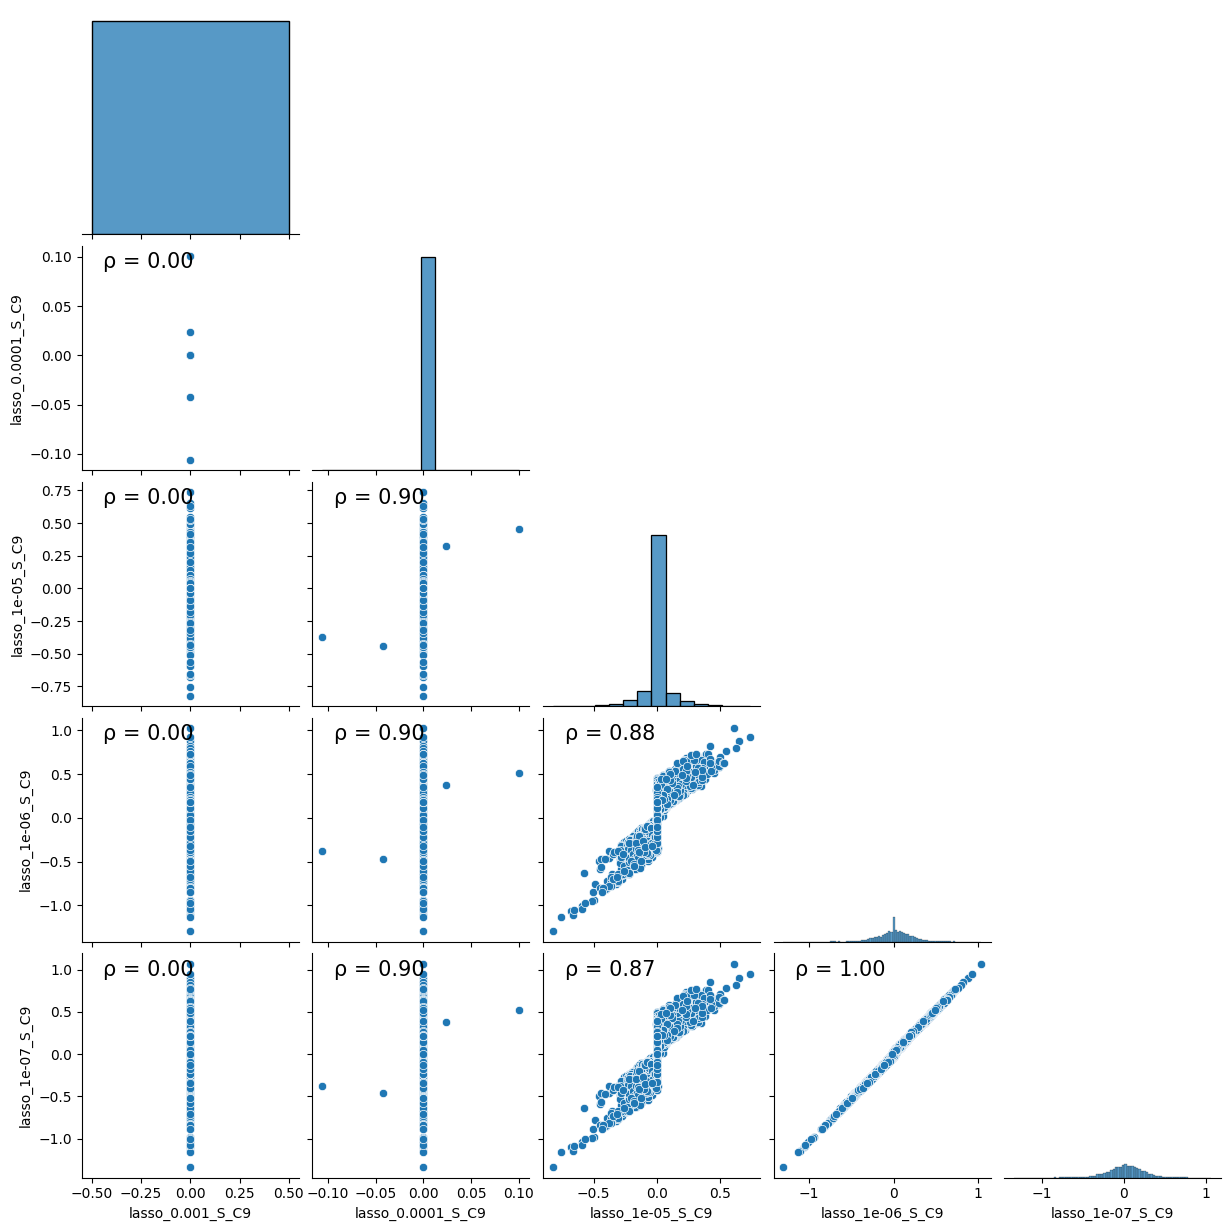

In [117]:
shifts = [col for col in mut_df.columns if "S_C9" in col and "avg" not in col]
g = sns.pairplot(mut_df, vars = shifts, corner=True)
g.map_lower(corrfunc)
plt.show()

In [128]:
mut_df.to_csv("../results/sweep_mut_df.csv")

In [119]:
models

dataset δ_huber λ_lasso_shift  \
0  <multidms.data.MultiDmsData object at 0x7f0004...       1         0.001   
1  <multidms.data.MultiDmsData object at 0x7f0004...       1        0.0001   
2  <multidms.data.MultiDmsData object at 0x7f0004...       1       0.00001   
3  <multidms.data.MultiDmsData object at 0x7f0004...       1      0.000001   
4  <multidms.data.MultiDmsData object at 0x7f0004...       1           0.0   

  λ_ridge_beta λ_ridge_shift λ_ridge_gamma data_idx epistatic_model  \
0            0             0             0        0        Identity   
1            0             0             0        0        Identity   
2            0             0             0        0        Identity   
3            0             0             0        0        Identity   
4            0             0             0        0        Identity   

  output_activation lock_beta  ... warmup_beta      tol num_training_steps  \
0          Identity     False  ...       False  0.00001                 10   
1          Identity     False  ...       False  0.00001                 10   
2          Identity     False  ...       False  0.00001                 10   
3          Identity     False  ...       False  0.00001                 10   
4          Identity     False  ...       False  0.00001                 10   

  iterations_per_step save_model_at PRNGKey  \
0                2000       [20000]       0   
1                2000       [20000]       0   
2                2000       [20000]       0   
3                2000       [20000]       0   
4                2000       [20000]       0   

                                           step_loss  \
0  [0.14120030483307966, 0.11347927285598562, 0.1...   
1  [0.16401121565743773, 0.12622718895955395, 0.1...   
2  [0.1574615069605372, 0.1231422880323718, 0.113...   
3  [0.15818456527493763, 0.12335676994755468, 0.1...   
4  [0.1582842836196246, 0.1235535279587429, 0.113...   

                                         model_20000 replicate  \
0  <multidms.model.MultiDmsModel object at 0x7f00...      Rep3   
1  <multidms.model.MultiDmsModel object at 0x7f00...      Rep3   
2  <multidms.model.MultiDmsModel object at 0x7f00...      Rep3   
3  <multidms.model.MultiDmsModel object at 0x7eff...      Rep3   
4  <multidms.model.MultiDmsModel object at 0x7eff...      Rep3   

            target  
0  abundance_score  
1  abundance_score  
2  abundance_score  
3  abundance_score  
4  abundance_score  

[5 rows x 24 columns]

In [125]:
print(models.loc[0])
models.loc[0].model_20000.mut_shift_plot(include_beta=False)

dataset                <multidms.data.MultiDmsData object at 0x7f0004...
δ_huber                                                                1
λ_lasso_shift                                                      0.001
λ_ridge_beta                                                           0
λ_ridge_shift                                                          0
λ_ridge_gamma                                                          0
data_idx                                                               0
epistatic_model                                                 Identity
output_activation                                               Identity
lock_beta                                                          False
lock_C_ref                                                           1.0
gamma_corrected                                                    False
conditional_c                                                      False
init_C_ref                                         

/home/jgallowa/miniconda3/envs/multidms_toml/lib/python3.10/site-packages/altair/utils/core.py:317: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col_name, dtype in df.dtypes.iteritems():


alt.VConcatChart(...)

In [126]:
print(models.loc[2])
models.loc[2].model_20000.mut_shift_plot(include_beta=False)

dataset                <multidms.data.MultiDmsData object at 0x7f0004...
δ_huber                                                                1
λ_lasso_shift                                                    0.00001
λ_ridge_beta                                                           0
λ_ridge_shift                                                          0
λ_ridge_gamma                                                          0
data_idx                                                               0
epistatic_model                                                 Identity
output_activation                                               Identity
lock_beta                                                          False
lock_C_ref                                                           1.0
gamma_corrected                                                    False
conditional_c                                                      False
init_C_ref                                         

/home/jgallowa/miniconda3/envs/multidms_toml/lib/python3.10/site-packages/altair/utils/core.py:317: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col_name, dtype in df.dtypes.iteritems():


alt.VConcatChart(...)

In [127]:
print(models.loc[4])
models.loc[4].model_20000.mut_shift_plot(include_beta=False)

dataset                <multidms.data.MultiDmsData object at 0x7f0004...
δ_huber                                                                1
λ_lasso_shift                                                        0.0
λ_ridge_beta                                                           0
λ_ridge_shift                                                          0
λ_ridge_gamma                                                          0
data_idx                                                               0
epistatic_model                                                 Identity
output_activation                                               Identity
lock_beta                                                          False
lock_C_ref                                                           1.0
gamma_corrected                                                    False
conditional_c                                                      False
init_C_ref                                         

/home/jgallowa/miniconda3/envs/multidms_toml/lib/python3.10/site-packages/altair/utils/core.py:317: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col_name, dtype in df.dtypes.iteritems():


alt.VConcatChart(...)